In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.models import resnet50
from torch.utils.data import DataLoader

#for grad-cam
import numpy as np
import matplotlib.pyplot as plt
import cv2 

c:\Users\Henry\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
# Check if CUDA is available
if torch.cuda.is_available():
    # Set the default tensor type to CUDA tensors
    torch.set_default_tensor_type(torch.cuda.FloatTensor)

    # Define the device as the first visible cuda device if available
    device = torch.device("cuda:0")
    print(f"Running on {torch.cuda.get_device_name(device)}")
else:
    device = torch.device("cpu")
    print("Running on CPU")


Running on NVIDIA GeForce RTX 3080


c:\Users\Henry\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ..\torch\csrc\tensor\python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)


In [9]:
# Data loaders for your deep fake and genuine images dataset
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # Normalization with ImageNet mean and std
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [10]:
# Updated paths for the datasets
train_dataset_path = "C:/Users/Henry/Downloads/archive/Dataset/train"
val_dataset_path = "C:/Users/Henry/Downloads/archive/Dataset/validation"
# test_dataset_path = "C:/Users/Henry/Downloads/archive/Dataset/test"  # Uncomment this if you have a test dataset

# Ensure train_transform is defined correctly
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    # Add other transformations as needed
])

# Load datasets
train_dataset = datasets.ImageFolder(train_dataset_path, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=8, generator=torch.Generator(device='cuda'))

val_dataset = datasets.ImageFolder(val_dataset_path, transform=train_transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=8)



In [11]:
# Initialize ResNet model and modify the last layer
model = resnet50(pretrained=True)
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, 2)  # Assuming 2 classes: genuine and deep fake
model = model.to(device)

c:\Users\Henry\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Henry\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [13]:
num_epochs = 1
for epoch in range(num_epochs):  # 10 epochs, adjust as needed
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)


        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


        if (i + 1) % 100 == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")


Epoch [1/1], Step [100/4376], Loss: 0.4006
Epoch [1/1], Step [200/4376], Loss: 0.1366
Epoch [1/1], Step [300/4376], Loss: 0.1231
Epoch [1/1], Step [400/4376], Loss: 0.3521
Epoch [1/1], Step [500/4376], Loss: 0.0685
Epoch [1/1], Step [600/4376], Loss: 0.2162
Epoch [1/1], Step [700/4376], Loss: 0.1335
Epoch [1/1], Step [800/4376], Loss: 0.1136
Epoch [1/1], Step [900/4376], Loss: 0.0593
Epoch [1/1], Step [1000/4376], Loss: 0.1593
Epoch [1/1], Step [1100/4376], Loss: 0.1230
Epoch [1/1], Step [1200/4376], Loss: 0.1073
Epoch [1/1], Step [1300/4376], Loss: 0.0510
Epoch [1/1], Step [1400/4376], Loss: 0.0593
Epoch [1/1], Step [1500/4376], Loss: 0.0602
Epoch [1/1], Step [1600/4376], Loss: 0.0519
Epoch [1/1], Step [1700/4376], Loss: 0.1038
Epoch [1/1], Step [1800/4376], Loss: 0.1438
Epoch [1/1], Step [1900/4376], Loss: 0.2585
Epoch [1/1], Step [2000/4376], Loss: 0.0473
Epoch [1/1], Step [2100/4376], Loss: 0.1024
Epoch [1/1], Step [2200/4376], Loss: 0.2216
Epoch [1/1], Step [2300/4376], Loss: 0.13

In [14]:
# Validation Loop
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()


    print(f"Validation Accuracy: {100 * correct / total}%")


Validation Accuracy: 90.74008318961144%


In [15]:
def grad_cam(model, image, target_class, layer_name='layer4'):
    """
    Generates a Grad-CAM heatmap for a specified class over an image.

    :param model: The CNN model.
    :param image: Input image (tensor).
    :param target_class: Target class (integer).
    :param layer_name: Name of the layer to be visualized.
    :return: Grad-CAM heatmap.
    """

    # 1. Forward pass to get the outputs and find the class index
    model.eval()
    outputs = model(image)
    class_idx = torch.argmax(outputs, axis=1).item() if target_class is None else target_class

    # 2. Zero the gradients
    model.zero_grad()

    # 3. Get the score for the target class
    score = outputs[:, class_idx]

    # 4. Backward pass to get gradients of the score for the target class
    score.backward(retain_graph=True)

    # 5. Get the gradients from the selected layer
    gradients = model.get_activations_gradient()  # Updated method name

    # 6. Pool the gradients across the channels
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

    # 7. Fetch the activations of the last convolutional layer
    activations = model.get_activations(image).detach()

    # 8. Weight the channels by corresponding gradients
    for i in range(activations.shape[1]):
        activations[:, i, :, :] *= pooled_gradients[i]

    # 9. Average the channels of the activations
    heatmap = torch.mean(activations, dim=1).squeeze()

    # 10. Normalize the heatmap
    heatmap = np.maximum(heatmap.cpu(), 0)
    heatmap /= torch.max(heatmap)

    # 11. Convert heatmap to numpy
    heatmap = heatmap.numpy()

    return heatmap

def plot_heatmap(heatmap, original_image, alpha=0.4, display=False):
    """
    Plots a heatmap over an original image.

    :param heatmap: Generated heatmap.
    :param original_image: Original image (numpy array).
    :param alpha: Transparency factor for the heatmap overlay.
    :param display: If True, displays the plot.
    :return: Image with heatmap.
    """
    # Resize heatmap to match the image size
    heatmap = cv2.resize(heatmap, (original_image.shape[1], original_image.shape[0]))

    # Convert heatmap to RGB
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Superimpose the heatmap on original image
    superimposed_img = heatmap * alpha + original_image

    if display:
        plt.imshow(superimposed_img / 255)
        plt.axis('off')
        plt.show()

    return superimposed_img



In [16]:

class ModifiedResNet(nn.Module):
    def __init__(self, original_model):
        super(ModifiedResNet, self).__init__()
        self.features = nn.Sequential(*list(original_model.children())[:-2])  # Exclude the last two layers
        self.avgpool = original_model.avgpool
        self.fc = original_model.fc

        self.gradients = None

    def activations_hook(self, grad):
        self.gradients = grad

    def forward(self, x):
        x = self.features(x)
        h = x.register_hook(self.activations_hook)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

    def get_activations_gradient(self):
        return self.gradients

    def get_activations(self, x):
        return self.features(x)

# Load the original ResNet model and modify it
original_model = resnet50(pretrained=True)
model = ModifiedResNet(original_model)
model = model.to(device)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


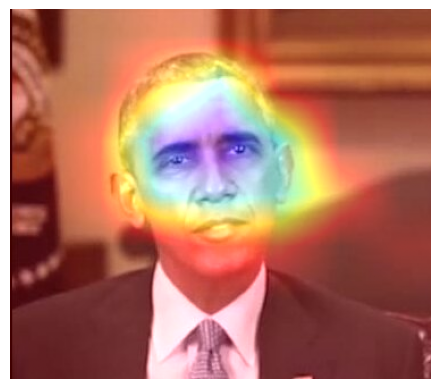

In [17]:
from PIL import Image

# Example usage of Grad-CAM (make sure to replace 'path/to/your/image.jpg' with an actual image path)
# Load and preprocess an image
input_image = Image.open('C:/Users/Henry/Downloads/image.jpg') # Replace with your own image path
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_tensor = input_tensor.to(device)
input_batch = input_tensor.unsqueeze(0)  # Create a mini-batch as expected by the model

# Generate the heatmap for a specific class (e.g., class index 0)
heatmap = grad_cam(model, input_batch, target_class=0)

# Convert tensor image to numpy array and overlay the heatmap
original_image = np.array(input_image)
superimposed_image = plot_heatmap(heatmap, original_image, alpha=0.5, display=True)
